In [729]:
import pandas as pd
import re
import os
import numpy as np
import datetime

In [742]:
csv_list = []
LUIGI_LOG_PATH='/usr/local/trustyou/home/andream/nfs/processmining/minilogs'
for filename in os.listdir(LUIGI_LOG_PATH):
    if filename.endswith('.csv'):
        # log_path = LUIGI_LOG_PATH+'/'+filename
        csv_list.append(filename)
csv_list
appended_df = pd.DataFrame()

In [745]:
filename='daily.2019-09-01_09-29-01.csv'

for filename in os.listdir(LUIGI_LOG_PATH):
    if filename.endswith('.csv'):
        log_path = LUIGI_LOG_PATH+'/'+filename
        print('Preprocessing... ',log_path)
        df = pd.read_csv(log_path, index_col=0)
        df = df[['timestamp','task','state']]
        df['source_file'] = filename

        df['state'][0]='start'
        df['task'][0]='AllTasks'

        df['state'][len(df)-1]='done'
        df['task'][len(df)-1]='AllTasks'
        
        appended_df = appended_df.append(df)
        continue
    else:
        continue

#df = pd.read_csv(LUIGI_LOG_PATH+'/'+filename, index_col=0)

# df['pid'] = df['pid'].astype(str)  
# df['pid'] = df['pid'].str.replace('.0', ' ')
# df['pid'] = df['pid'].replace('nan', np.nan, regex=True)


# df = df[['timestamp','task','state']]
# df['source_file'] = filename

# df['state'][0]='start'
# df['task'][0]='AllTasks'

# df['state'][len(df)-1]='done'
# df['task'][len(df)-1]='AllTasks'

# appended_df.append(df)
# appended_df = pd.concat(appended_df)

print(len(appended_df))
appended_df.head()

Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-04_23-23-01.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-09_01-34-02.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-16_19-44-01.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-20_12-49-01.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-24_05-05-02.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-11_05-40-02.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-13_04-11-01.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-06_20-34-01.csv
Preprocessing...  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily.2019-09-18_14-08-01.csv
Preprocessing...  /usr/local

,timestamp,task,state,source_file
0,2019-09-04 23:23:20,AllTasks,start,daily.2019-09-04_23-23-01.csv
1,2019-09-04 23:35:08,"DumpTask(date=2019-09-04_23-23-01, prev_date=2019-09-03_03-44-01, chunk=prep, sql_filename=daily...",start,daily.2019-09-04_23-23-01.csv
2,2019-09-04 23:35:08,"DumpTask(date=2019-09-04_23-23-01, prev_date=2019-09-03_03-44-01, chunk=prep, sql_filename=regul...",start,daily.2019-09-04_23-23-01.csv
3,2019-09-04 23:35:08,"DumpTask(date=2019-09-04_23-23-01, prev_date=2019-09-03_03-44-01, chunk=prep, sql_filename=repro...",start,daily.2019-09-04_23-23-01.csv
4,2019-09-04 23:35:08,"ProxySetupTask(date=2019-09-04_23-23-01, prev_date=2019-09-03_03-44-01, chunk=prep)\n",start,daily.2019-09-04_23-23-01.csv


In [746]:
def get_task(task_call):
    if isinstance(task_call, float):
        return task_call
    return task_call.split('(')[0]

In [757]:
df = appended_df
df['task_call'] = df['task']
df['task_name'] = np.where(df['task'].notnull(), df['task'].apply(get_task), df['task'])
df = df[['task_name','state','timestamp','task_call', 'source_file']]

In [758]:
df['start_time'] = np.where(df['state']=='start', df['timestamp'], np.nan)
df['end_time'] = np.where(df['state']=='done', df['timestamp'], np.nan)

In [759]:
start_df = df[df['state']=='start']
print(len(start_df))

end_df = df[df['state']=='done']
print(len(end_df))

32710
32646


In [760]:
all_df = pd.merge(start_df, end_df, on=['task_call', 'source_file'], how='outer')
print(len(all_df))

69140


In [761]:
def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

In [770]:
all_df = all_df[all_df['start_time_x'].notnull()]
all_df = all_df[all_df['end_time_y'].notnull()]
print(len(all_df))

69104


In [776]:
all_df['start_time'] = all_df['start_time_x']
all_df['end_time'] = all_df['end_time_y']
all_df['duration'] = all_df.apply(lambda row: str(get_duration(row['start_time'],row['end_time'])), axis=1)
all_df['t_duration']= all_df.apply(lambda row: get_duration(row['start_time'],row['end_time']).total_seconds(), axis=1)
all_df['task_name'] = all_df['task_name_x']

dur_df = all_df[['task_name','duration','task_call','start_time','end_time', 'source_file', 't_duration']]
print(len(dur_df))
dur_df = dur_df.sort_values(by=['t_duration','task_name'], ascending=False)
dur_df = dur_df[dur_df['task_name']!='AllTasks']
dur_df = dur_df.head(5000)

69104


In [777]:
#for name, group in df.groupby(['task_call'],as_index=False):
#    print(name)
#    print(group)

In [778]:
pd.options.display.max_colwidth = 100
grouped = df.groupby(['task_call'],as_index=False)
# grouped.size()

In [779]:
import matplotlib.pyplot as plt
import seaborn as sns

5000
       task_name  \
20204  GroupTask   

                                                                                                 task_call  \
20204  GroupTask(date=2019-09-16_19-44-01, prev_date=2019-09-15_01-41-01, chunk=01, datacenter=eu, inc=...   

       t_duration  
20204     82321.0  


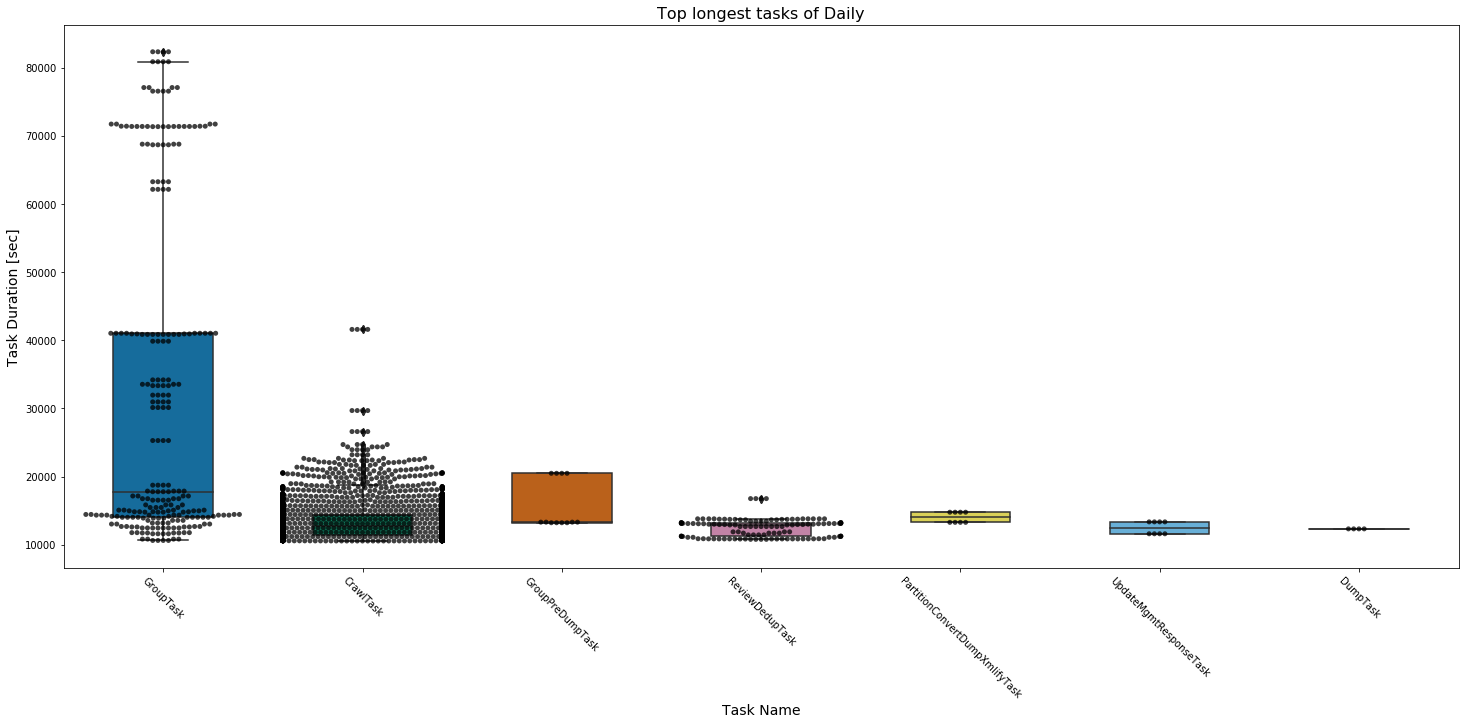

In [780]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=-45)
task_duration= dur_df[['task_name','task_call','t_duration']]
print(len(task_duration))
print(task_duration.head(1))
task_duration.shape

# plot boxplot with seaborn
bplot=sns.boxplot(y='t_duration', x='task_name', 
                 data=task_duration, 
                 width=0.5,
                 palette="colorblind")
 
# add swarmplot
bplot=sns.swarmplot(y='t_duration', x='task_name',
              data=task_duration, 
              color='black',
              alpha=0.75)

bplot.axes.set_title("Top longest tasks of Daily",
                    fontsize=16)
 
bplot.set_xlabel("Task Name", 
                fontsize=14)
 
bplot.set_ylabel("Task Duration [sec]",
                fontsize=14)
 
bplot.tick_params(labelsize=10)